In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
from time import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from model.models import models_perform
from statistics import mean
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from detect_outliers import detect_outliers
from helperFunctions import *
from modelsAnalysis import *

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGB
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from model.MyIBL import MyIBL as IBL
from sklearn.linear_model import LogisticRegression as LG

In [3]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [5]:
clfs = [IBL(), RF(n_estimators =12), SVC(gamma='scale'), XGB(), MLP(max_iter=1000), KNN(), LDA()]

# No Process (without removing outliers)

In [6]:
trainData, testData, df_train1, labels1, df_test1, labels_test = runPreprocessing('noprocess', outliers=False)
df_train = df_train1
df_test = df_test1
labels = labels1
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: noprocess
(Number of outliers, threshold) (0, 0)
process_type: noprocess
(891, 12) (418, 12) (891,)
(891, 7) (418, 7)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3'], dtype='object')



MyIBL
MyIBL 0.7350825434687088 accuracy at validation stage, 9.381669759750366 s

RandomForestClassifier
RandomForestClassifier 0.8058753373925052 accuracy at validation stage, 0.15711188316345215 s


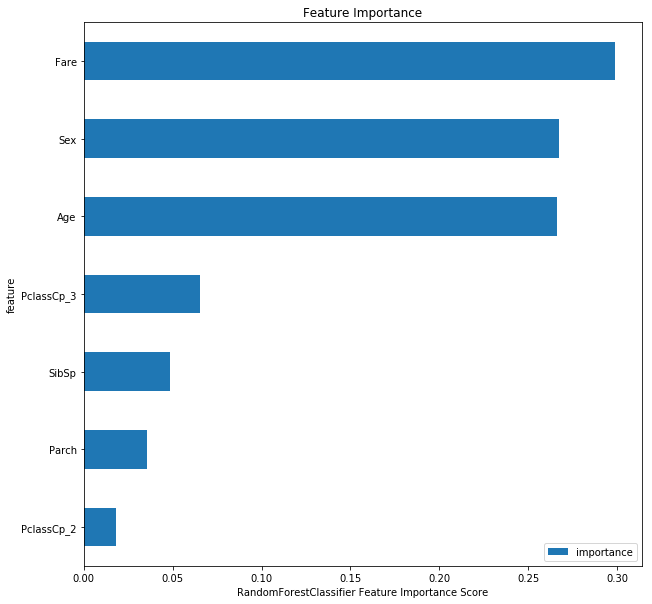


SVC
SVC 0.7990647165902957 accuracy at validation stage, 0.22916483879089355 s

XGBClassifier
XGBClassifier 0.8237712635741636 accuracy at validation stage, 0.3312342166900635 s


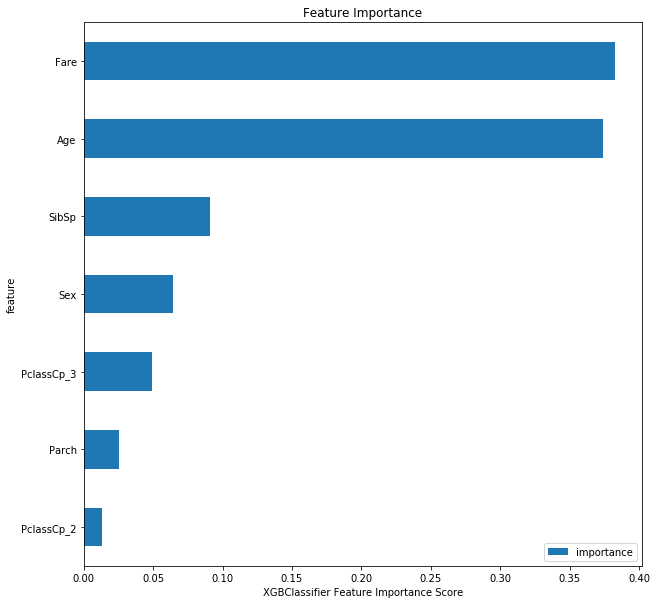


MLPClassifier
MLPClassifier 0.8204004770573097 accuracy at validation stage, 9.248962879180908 s

KNeighborsClassifier
KNeighborsClassifier 0.8182160567447115 accuracy at validation stage, 0.030016422271728516 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.7878601468834349 accuracy at validation stage, 0.02303147315979004 s


In [7]:
models1, df_model_cvaccuracies1, df_model_info1, df_ens_features1, df_ens_test1 = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [8]:
for model in models1:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

#submitIt(testData.PassengerId, df_test, models1[3], 'preprocess1')

MyIBL 0.69377990430622
RandomForestClassifier 0.7511961722488039
SVC 0.777511961722488
XGBClassifier 0.7607655502392344
MLPClassifier 0.7679425837320574
KNeighborsClassifier 0.7679425837320574
LinearDiscriminantAnalysis 0.7751196172248804


# No process (removing outliers)

In [9]:
trainData, testData, df_train1_o, labels1_o, df_test1_o, labels_test = runPreprocessing('noprocess', outliers=True)
df_train = df_train1_o
df_test = df_test1_o
labels = labels1_o
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: noprocess
(Number of outliers, threshold) (33, 133.65)
process_type: noprocess
(891, 12) (418, 12) (858,)
(858, 7) (418, 7)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3'], dtype='object')



MyIBL
MyIBL 0.7552087583299334 accuracy at validation stage, 8.366931438446045 s

RandomForestClassifier
RandomForestClassifier 0.8088875288997688 accuracy at validation stage, 0.08507895469665527 s


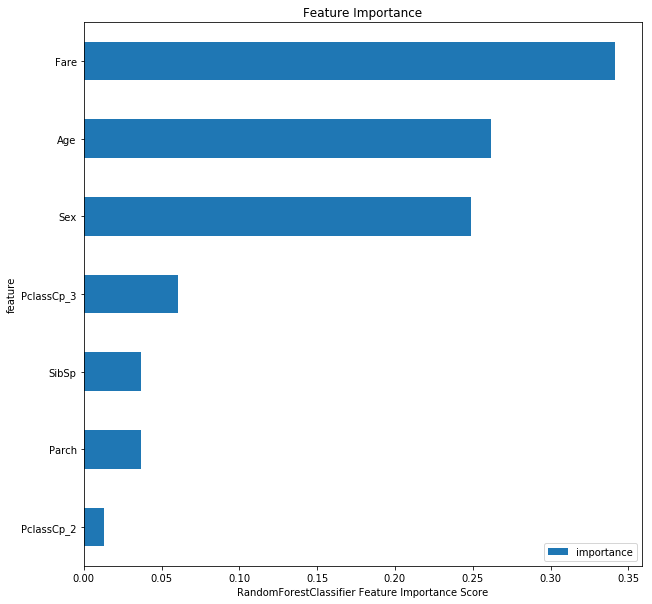


SVC
SVC 0.8006731946144431 accuracy at validation stage, 0.06203150749206543 s

XGBClassifier
XGBClassifier 0.8240106079151367 accuracy at validation stage, 0.28820204734802246 s


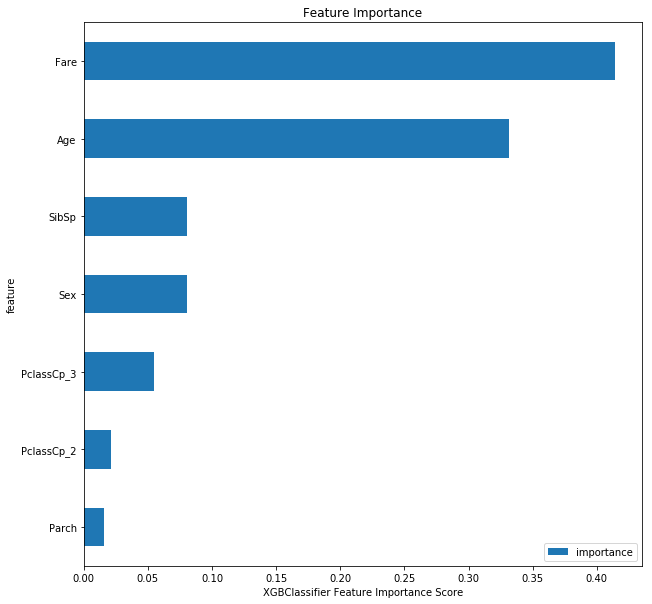


MLPClassifier
MLPClassifier 0.8088807289541683 accuracy at validation stage, 4.7854814529418945 s

KNeighborsClassifier
KNeighborsClassifier 0.8065687474500204 accuracy at validation stage, 0.027016162872314453 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.7913844689242486 accuracy at validation stage, 0.022016525268554688 s


In [10]:
models1_o, df_model_cvaccuracies1_o, df_model_info1_o, df_ens_features1_o, df_ens_test1_o = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [11]:
for model in models1_o:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

#submitIt(testData.PassengerId, df_test, models1_o[3], 'preprocess1_o')

MyIBL 0.6913875598086124
RandomForestClassifier 0.7344497607655502
SVC 0.7751196172248804
XGBClassifier 0.7535885167464115
MLPClassifier 0.777511961722488
KNeighborsClassifier 0.7631578947368421
LinearDiscriminantAnalysis 0.777511961722488


# Standard preprocess (without removing outliers)

In [12]:
trainData, testData, df_train2, labels2, df_test2, labels_test = runPreprocessing('standard', outliers=False)
df_train = df_train2
df_test = df_test2
labels = labels2
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: standard
(Number of outliers, threshold) (0, 0)
process_type: standard
(891, 12) (418, 12) (891,)
(891, 23) (418, 23)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X'], dtype='object')



MyIBL
MyIBL 0.7395832025610445 accuracy at validation stage, 8.038797855377197 s

RandomForestClassifier
RandomForestClassifier 0.8114744837110037 accuracy at validation stage, 0.3312339782714844 s


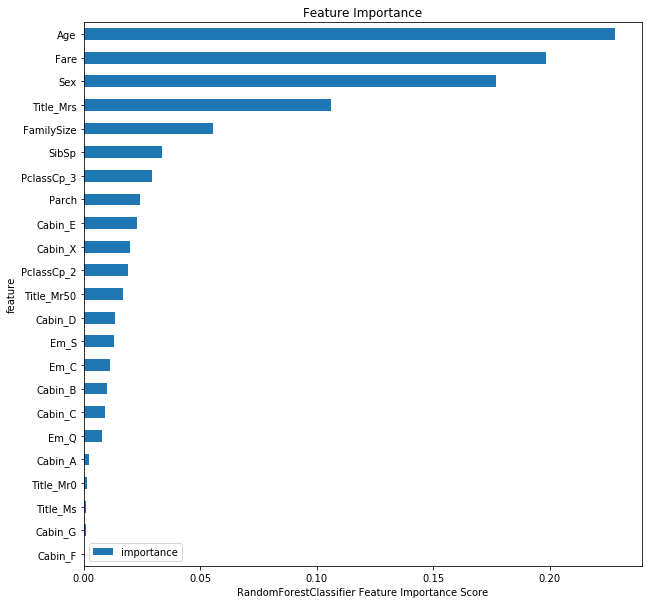


SVC
SVC 0.8192643274119641 accuracy at validation stage, 0.14009737968444824 s

XGBClassifier
XGBClassifier 0.8294206264515724 accuracy at validation stage, 0.5243914127349854 s


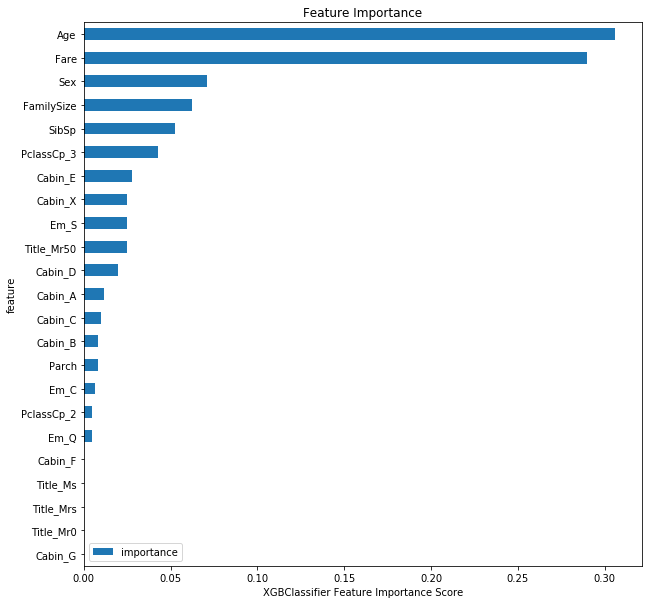


MLPClassifier
MLPClassifier 0.8159814198732032 accuracy at validation stage, 21.15972352027893 s

KNeighborsClassifier
KNeighborsClassifier 0.8047454648170234 accuracy at validation stage, 0.06904935836791992 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8148138848785387 accuracy at validation stage, 0.07205080986022949 s


In [13]:
models2, df_model_cvaccuracies2, df_model_info2, df_ens_features2, df_ens_test2 = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [14]:
for model in models2:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models2[2], 'preprocess2')

MyIBL 0.6435406698564593
RandomForestClassifier 0.7320574162679426
SVC 0.7966507177033493
XGBClassifier 0.7631578947368421
MLPClassifier 0.777511961722488
KNeighborsClassifier 0.7583732057416268
LinearDiscriminantAnalysis 0.784688995215311


# Standard preprocess (removing outliers)

In [15]:
trainData, testData, df_train2_o, labels2_o, df_test2_o, labels_test = runPreprocessing('standard', outliers=True)
df_train = df_train2_o
df_test = df_test2_o
labels = labels2_o
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: standard
(Number of outliers, threshold) (16, 133.65)
process_type: standard
(891, 12) (418, 12) (875,)
(875, 23) (418, 23)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X'], dtype='object')



MyIBL
MyIBL 0.7394285714285714 accuracy at validation stage, 12.554897785186768 s

RandomForestClassifier
RandomForestClassifier 0.7874285714285714 accuracy at validation stage, 0.09008312225341797 s


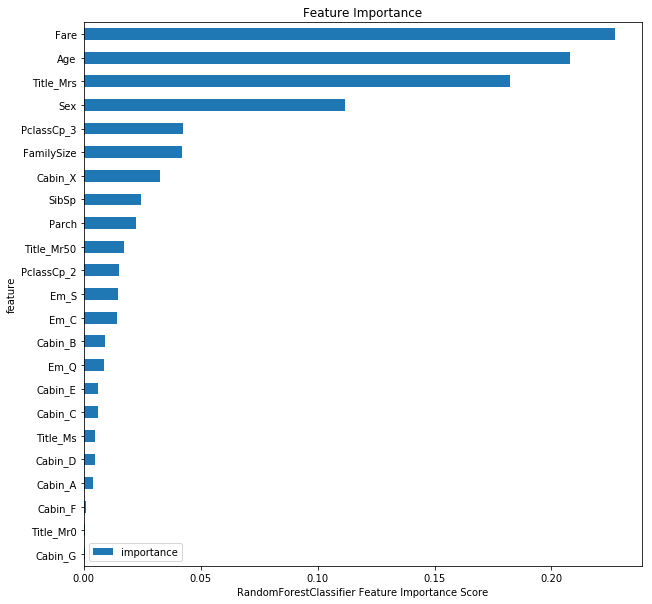


SVC
SVC 0.808 accuracy at validation stage, 0.09508752822875977 s

XGBClassifier
XGBClassifier 0.8274285714285714 accuracy at validation stage, 0.5013692378997803 s


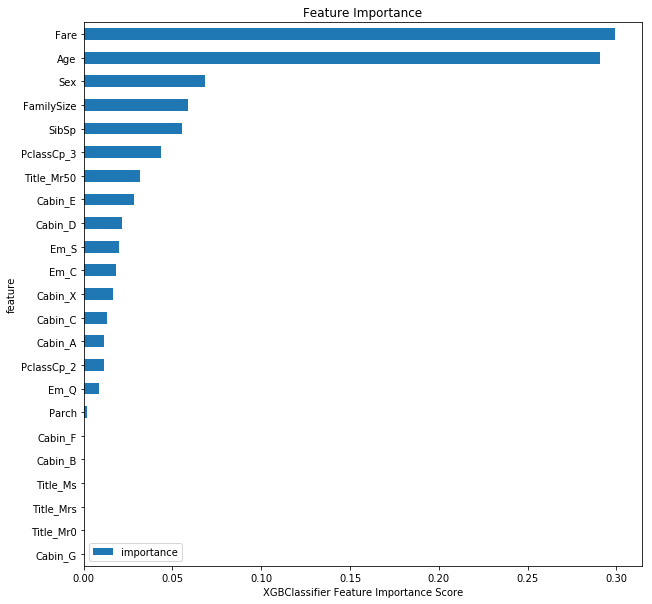


MLPClassifier
MLPClassifier 0.8148571428571428 accuracy at validation stage, 23.00044822692871 s

KNeighborsClassifier
KNeighborsClassifier 0.8068571428571428 accuracy at validation stage, 0.04104733467102051 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8091428571428572 accuracy at validation stage, 0.09306621551513672 s


In [16]:
models2_o, df_model_cvaccuracies2_o, df_model_info2_o, df_ens_features2_o, df_ens_test2_o = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [17]:
for model in models2_o:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models2_o[2], 'preprocess2_o')

MyIBL 0.6866028708133971
RandomForestClassifier 0.7392344497607656
SVC 0.7942583732057417
XGBClassifier 0.7559808612440191
MLPClassifier 0.7822966507177034
KNeighborsClassifier 0.7631578947368421
LinearDiscriminantAnalysis 0.784688995215311


# Preprocessing with categories (without removing outliers)

In [18]:
trainData, testData, df_train3, labels3, df_test3, labels_test = runPreprocessing('categorized', outliers=False)
df_train = df_train3
df_test = df_test3
labels = labels3
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: categorized
(Number of outliers, threshold) (0, 0)
process_type: categorized
(891, 12) (418, 12) (891,)
(891, 32) (418, 32)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High'], dtype='object')



MyIBL
MyIBL 0.7182851045132133 accuracy at validation stage, 11.973488092422485 s

RandomForestClassifier
RandomForestClassifier 0.7968740192078337 accuracy at validation stage, 0.1611161231994629 s


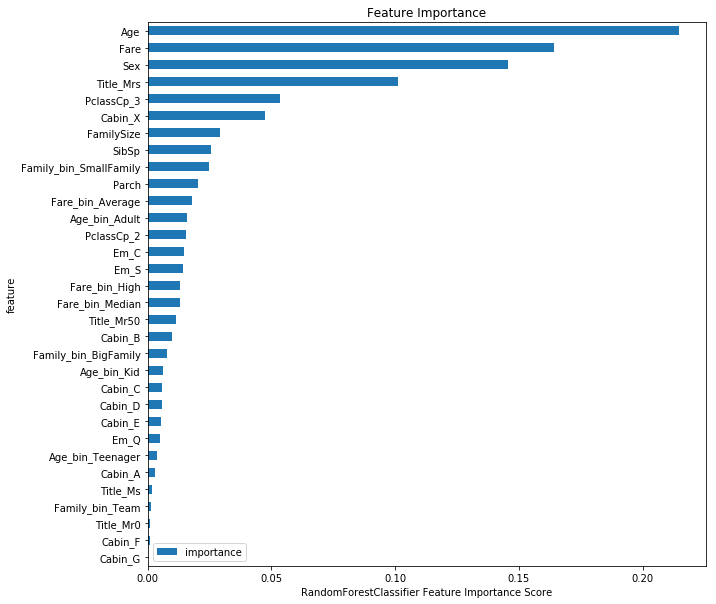


SVC
SVC 0.8316238779737619 accuracy at validation stage, 0.14009809494018555 s

XGBClassifier
XGBClassifier 0.8372669637813068 accuracy at validation stage, 0.8716311454772949 s


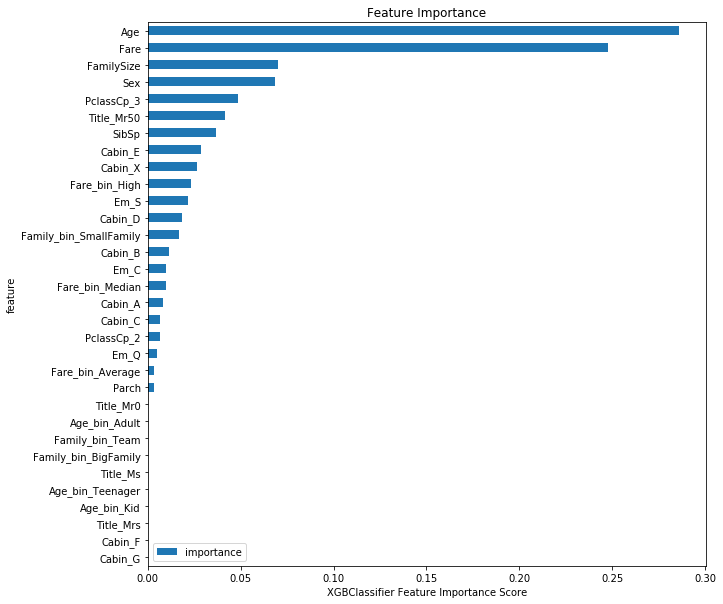


MLPClassifier
MLPClassifier 0.8215491808423827 accuracy at validation stage, 23.80519962310791 s

KNeighborsClassifier
KNeighborsClassifier 0.8204381394764924 accuracy at validation stage, 0.06104159355163574 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8249136902893729 accuracy at validation stage, 0.061429738998413086 s


In [19]:
models3, df_model_cvaccuracies3, df_model_info3, df_ens_features3, df_ens_test3 = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [20]:
for model in models3:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models1[3], 'preprocess3')

MyIBL 0.6770334928229665
RandomForestClassifier 0.7511961722488039
SVC 0.7799043062200957
XGBClassifier 0.7559808612440191
MLPClassifier 0.7727272727272727
KNeighborsClassifier 0.7679425837320574
LinearDiscriminantAnalysis 0.7655502392344498


# Preprocessing with categories (removing outliers)

In [21]:
trainData, testData, df_train3_o, labels3_o, df_test3_o, labels_test = runPreprocessing('categorized', outliers=True)
df_train = df_train3_o
df_test = df_test3_o
labels = labels3_o
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: categorized
(Number of outliers, threshold) (24, 133.65)
process_type: categorized
(891, 12) (418, 12) (867,)
(867, 32) (418, 32)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High'], dtype='object')



MyIBL
MyIBL 0.7335791641751378 accuracy at validation stage, 9.436707496643066 s

RandomForestClassifier
RandomForestClassifier 0.7993355923194472 accuracy at validation stage, 0.12911081314086914 s


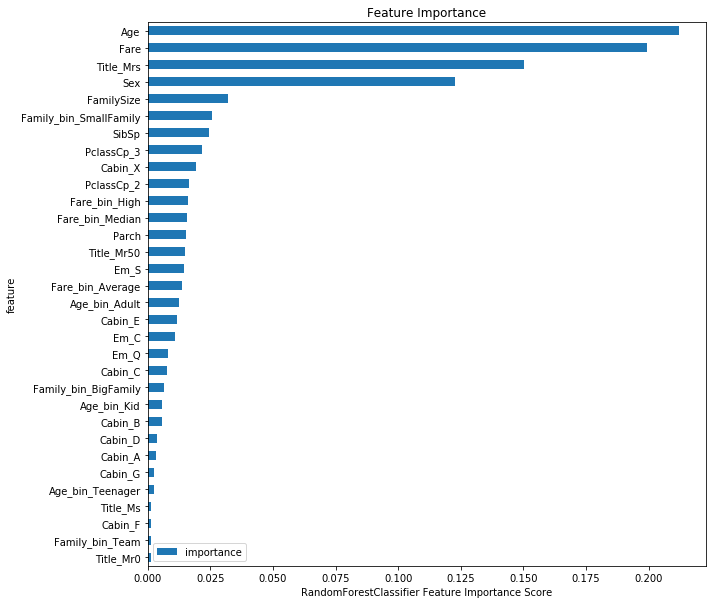


SVC
SVC 0.8258122383894758 accuracy at validation stage, 0.1181037425994873 s

XGBClassifier
XGBClassifier 0.8270347485216929 accuracy at validation stage, 0.6714944839477539 s


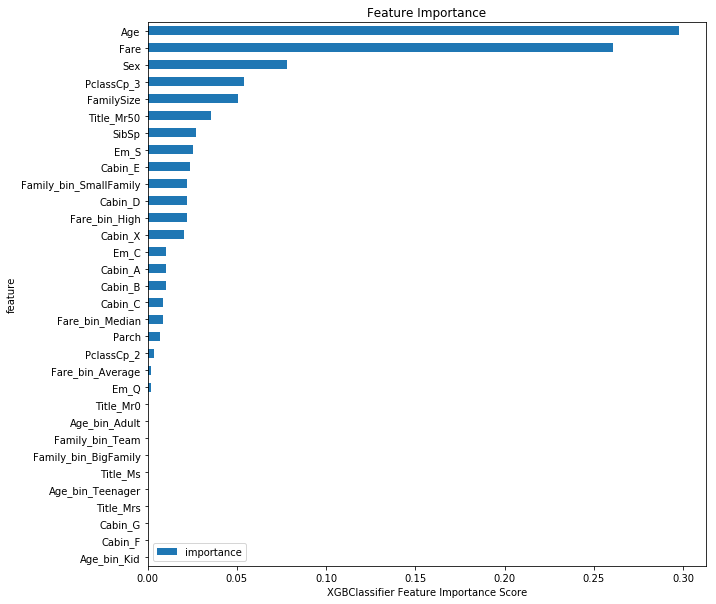


MLPClassifier
MLPClassifier 0.820138196797555 accuracy at validation stage, 19.986462354660034 s

KNeighborsClassifier
KNeighborsClassifier 0.8178061258388147 accuracy at validation stage, 0.047051191329956055 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8247026775629526 accuracy at validation stage, 0.056947946548461914 s


In [22]:
models3_o, df_model_cvaccuracies3_o, df_model_info3_o, df_ens_features3_o, df_ens_test3_o = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [23]:
for model in models3_o:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models3_o[3], 'preprocess3_o')

MyIBL 0.6866028708133971
RandomForestClassifier 0.7368421052631579
SVC 0.777511961722488
XGBClassifier 0.7679425837320574
MLPClassifier 0.7655502392344498
KNeighborsClassifier 0.7655502392344498
LinearDiscriminantAnalysis 0.7655502392344498


# All the preprocessing (without removing outliers)

In [24]:
trainData, testData, df_train4, labels4, df_test4, labels_test = runPreprocessing('all', outliers=False)
df_train = df_train4
df_test = df_test4
labels = labels4
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: all
(Number of outliers, threshold) (0, 0)
process_type: all
(891, 12) (418, 12) (891,)
(891, 49) (418, 49)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High', 'Mother', 'Father', 'Daughter', 'Son', 'Orphan', 'RichWoman', 'MiddleClassWoman', 'PoorWoman', 'RichMan', 'MiddleClassMan', 'PoorMan', 'RichGirl', 'MiddleClassGirl', 'PoorGirl', 'RichBoy', 'MiddleClassBoy', 'PoorBoy'], dtype='object')



MyIBL
MyIBL 0.736231247253782 accuracy at validation stage, 10.169358253479004 s

RandomForestClassifier
RandomForestClassifier 0.7979850605737242 accuracy at validation stage, 0.12410712242126465 s


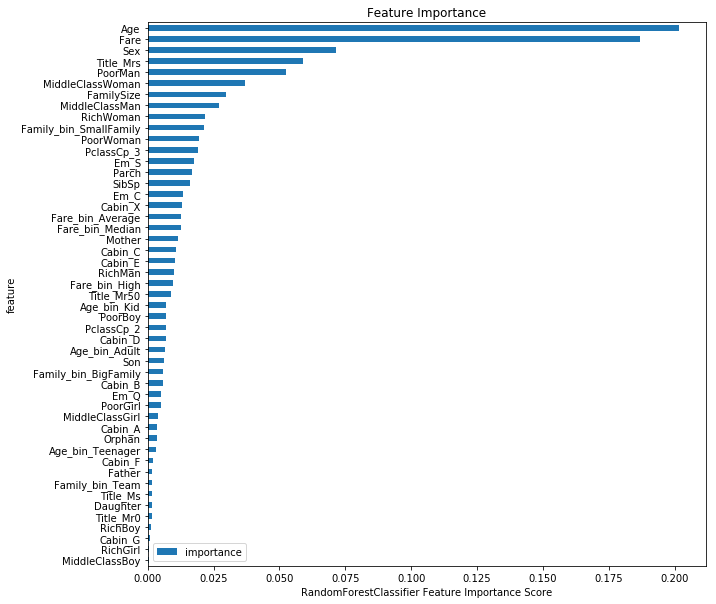


SVC
SVC 0.8316427091833533 accuracy at validation stage, 0.1871323585510254 s

XGBClassifier
XGBClassifier 0.8350260498399347 accuracy at validation stage, 1.1788356304168701 s


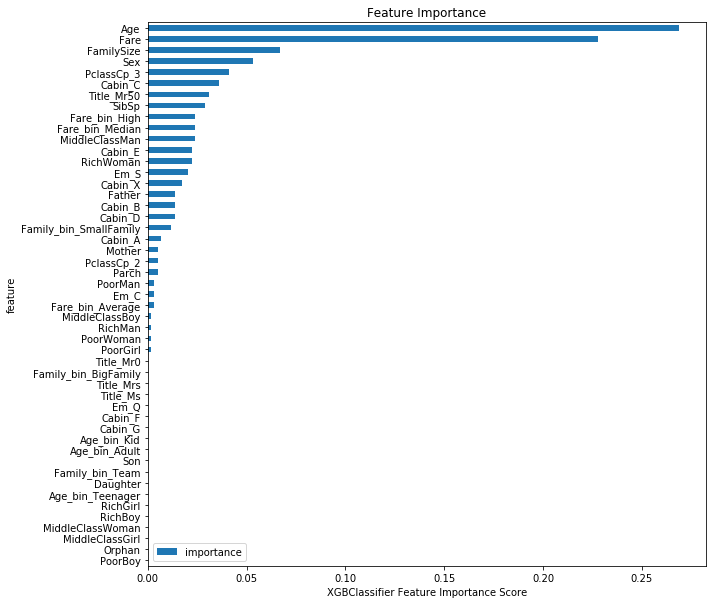


MLPClassifier
MLPClassifier 0.8204318624066286 accuracy at validation stage, 23.952528953552246 s

KNeighborsClassifier
KNeighborsClassifier 0.8215742891218379 accuracy at validation stage, 0.06805825233459473 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.81483271608813 accuracy at validation stage, 0.10007262229919434 s


In [25]:
models4, df_model_cvaccuracies4, df_model_info4, df_ens_features4, df_ens_test4 = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [26]:
for model in models4:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models4[3], 'preprocess4')

MyIBL 0.6985645933014354
RandomForestClassifier 0.7535885167464115
SVC 0.784688995215311
XGBClassifier 0.7679425837320574
MLPClassifier 0.7607655502392344
KNeighborsClassifier 0.7655502392344498
LinearDiscriminantAnalysis 0.7607655502392344



# All the preprocessing (removing outliers)

In [27]:
trainData, testData, df_train4_o, labels4_o, df_test4_o, labels_test = runPreprocessing('all', outliers=True)
df_train = df_train4_o
df_test = df_test4_o
labels = labels4_o
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
data/train.csv
data/test.csv
process_type: all
(Number of outliers, threshold) (3, 133.65)
process_type: all
(891, 12) (418, 12) (888,)
(888, 49) (418, 49)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High', 'Mother', 'Father', 'Daughter', 'Son', 'Orphan', 'RichWoman', 'MiddleClassWoman', 'PoorWoman', 'RichMan', 'MiddleClassMan', 'PoorMan', 'RichGirl', 'MiddleClassGirl', 'PoorGirl', 'RichBoy', 'MiddleClassBoy', 'PoorBoy'], dtype='object')



MyIBL
MyIBL 0.7500730019678791 accuracy at validation stage, 9.609812021255493 s

RandomForestClassifier
RandomForestClassifier 0.8006855836983432 accuracy at validation stage, 0.1270904541015625 s


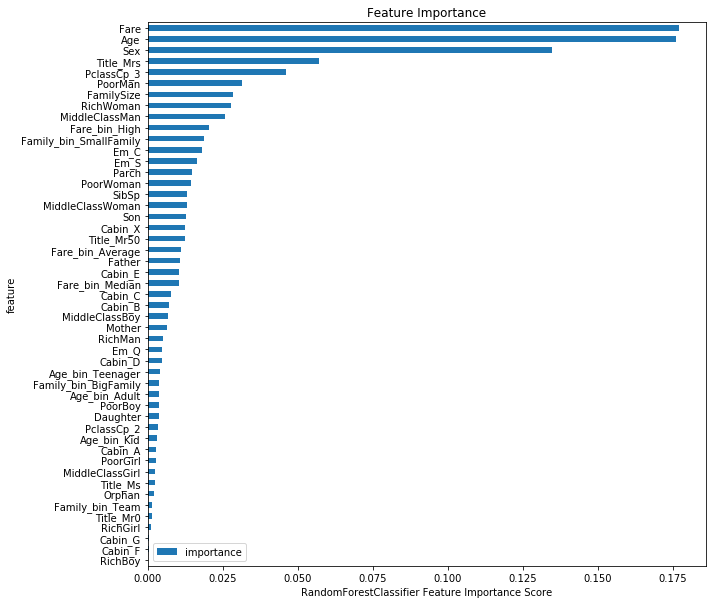


SVC
SVC 0.8310924903193043 accuracy at validation stage, 0.17615914344787598 s

XGBClassifier
XGBClassifier 0.8299625468164794 accuracy at validation stage, 1.147813081741333 s


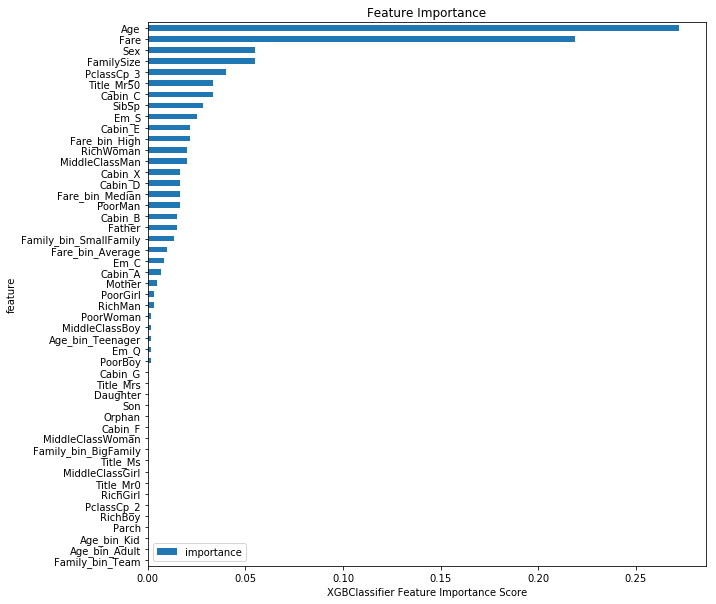


MLPClassifier
MLPClassifier 0.8119786707293849 accuracy at validation stage, 20.69613242149353 s

KNeighborsClassifier
KNeighborsClassifier 0.8209737827715355 accuracy at validation stage, 0.07104992866516113 s

LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8153367612518251 accuracy at validation stage, 0.1030740737915039 s


In [28]:
models4_o, df_model_cvaccuracies4_o, df_model_info4_o, df_ens_features4_o, df_ens_test4_o = run_models(clfs, df_train, labels, df_test, train_idx, validation_idx, cv=True, ens=True)

In [29]:
for model in models4_o:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))
#submitIt(testData.PassengerId, df_test, models4_o[3], 'preprocess4_o')

MyIBL 0.6650717703349283
RandomForestClassifier 0.7464114832535885
SVC 0.784688995215311
XGBClassifier 0.7631578947368421
MLPClassifier 0.7703349282296651
KNeighborsClassifier 0.7655502392344498
LinearDiscriminantAnalysis 0.7583732057416268


#

In [30]:
df = pd.concat([df_model_info1.Accuracy, df_model_info2.Accuracy, df_model_info3.Accuracy, df_model_info4.Accuracy], axis=1)
df.columns = [(df_train1.shape[0],df_train1.shape[1]), (df_train2.shape[0],df_train2.shape[1]), (df_train3.shape[0],df_train3.shape[1]), (df_train4.shape[0],df_train4.shape[1])]
#df

In [31]:
df_o = pd.concat([df_model_info1_o.Accuracy, df_model_info2_o.Accuracy, df_model_info3_o.Accuracy, df_model_info4_o.Accuracy], axis=1)
df_o.columns = [(df_train1_o.shape[0],df_train1_o.shape[1]), (df_train2_o.shape[0],df_train2_o.shape[1]), (df_train3_o.shape[0],df_train3_o.shape[1]), (df_train4_o.shape[0],df_train4_o.shape[1])]
#df_o

In [66]:
df_combined = pd.concat([df, df_o], axis=1)
df_combined

,"(891, 7)","(891, 23)","(891, 32)","(891, 49)","(858, 7)","(875, 23)","(867, 32)","(888, 49)"
MyIBL,0.723083,0.727583,0.706285,0.736231,0.743209,0.727429,0.721579,0.758073
RandomForestClassifier,0.793875,0.799474,0.784874,0.797985,0.796888,0.775429,0.787336,0.808686
SVC,0.787065,0.807264,0.819624,0.831643,0.788673,0.796000,0.813812,0.839092
XGBClassifier,0.811771,0.817421,0.825267,0.835026,0.812011,0.815429,0.815035,0.837963
MLPClassifier,0.808400,0.803981,0.809549,0.820432,0.796881,0.802857,0.808138,0.819979
KNeighborsClassifier,0.806216,0.792745,0.808438,0.821574,0.794569,0.794857,0.805806,0.828974
LinearDiscriminantAnalysis,0.775860,0.802814,0.812914,0.814833,0.779384,0.797143,0.812703,0.823337


In [33]:
print(df_combined.columns[df_combined.values.argmax(axis=1)], df_combined.values.max(axis=1)) 
print(df_combined.index[df_combined.values.argmax(axis=0)], df_combined.values.max(axis=0))

Index([(858, 7), (891, 23), (891, 49), (891, 32), (891, 32), (891, 49), (891, 32)], dtype='object') [0.75520876 0.81147448 0.83164271 0.83726696 0.82154918 0.82157429
 0.82491369]
Index(['XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'SVC'], dtype='object') [0.82377126 0.82942063 0.83726696 0.83502605 0.82401061 0.82742857
 0.82703475 0.83109249]


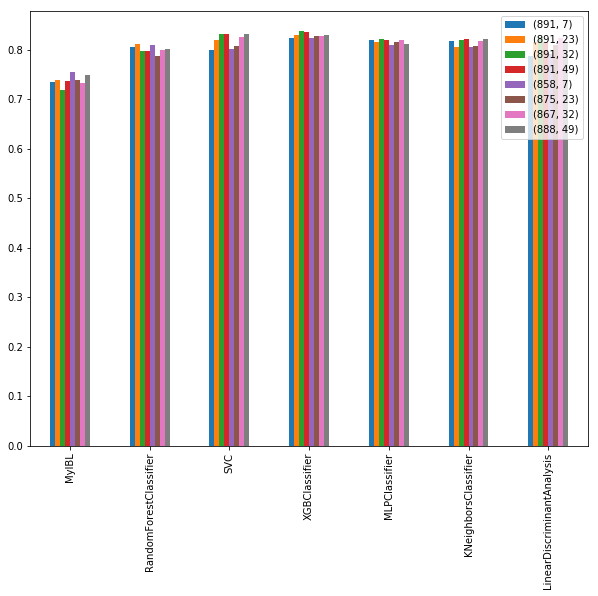

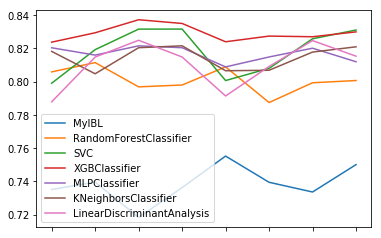

In [34]:
df_combined.plot.bar(figsize=(10,8))
df_combined.transpose().plot()

In [35]:
#from importlib import reload
#import  modelsAnalysis
#modelsAnalysis = reload(modelsAnalysis)
#from modelsAnalysis import *

# Ensemble model

## Ensemble No Process (without removing outliers)


XGBClassifier
XGBClassifier 0.8305442219571904 accuracy at validation stage, 0.21817445755004883 s


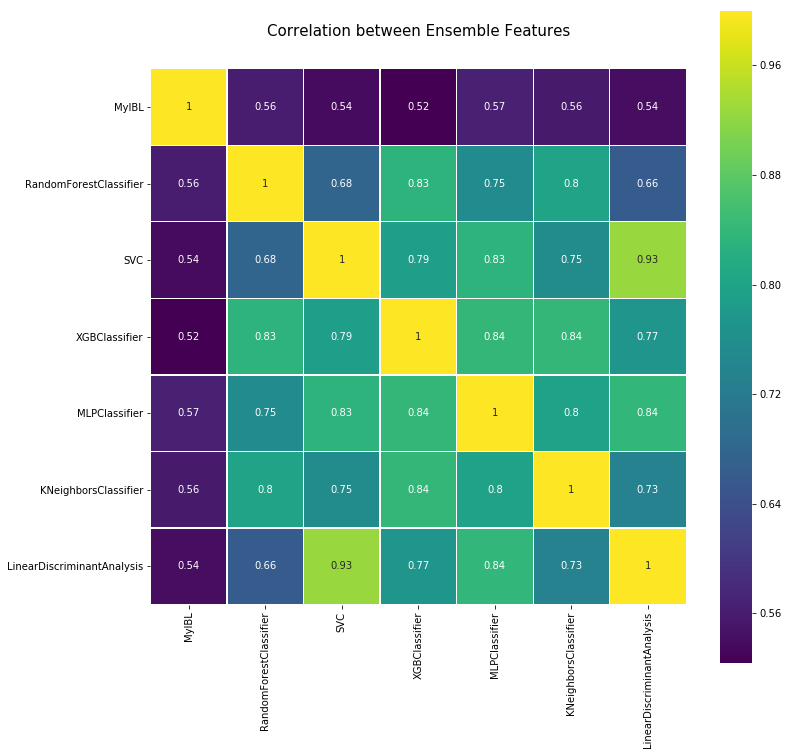

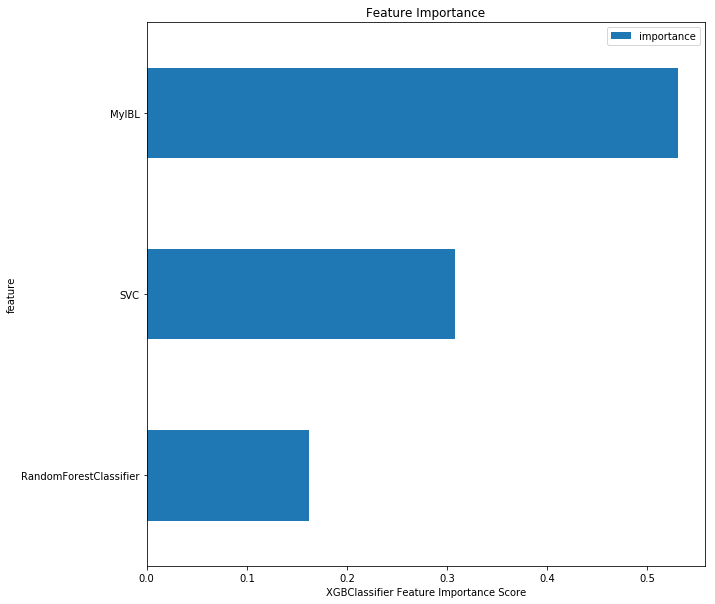

In [36]:
df_ens_features = df_ens_features1
df_ens_test = df_ens_test1
df_new_test = df_test1
labels = labels1
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC', 'RandomForestClassifier']]
df_test = df_ens_test[['MyIBL', 'SVC', 'RandomForestClassifier']]
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_1, _, df_model_info_ens1, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [37]:
model_ens_1[0].score(df_test, labels_test)

0.7703349282296651

## Ensemble No Process (removing outliers)


XGBClassifier
XGBClassifier 0.8006731946144431 accuracy at validation stage, 0.18012785911560059 s


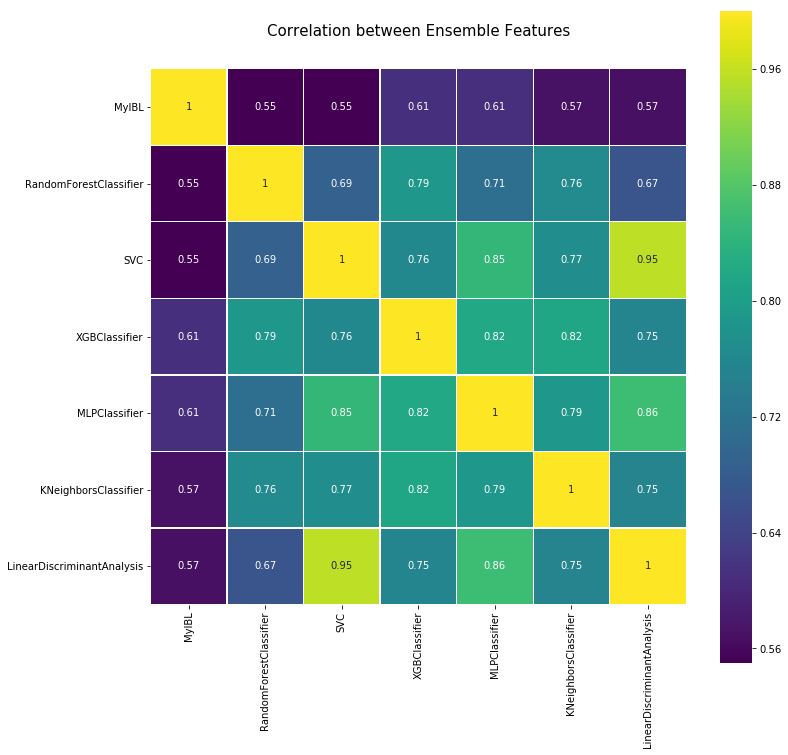

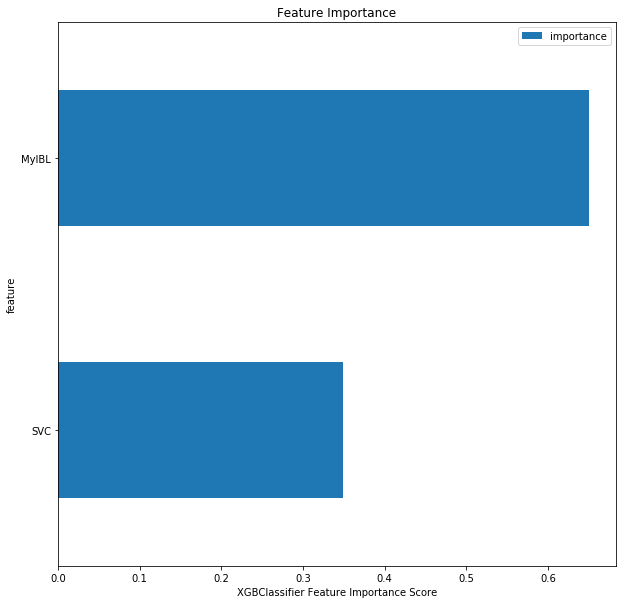

In [38]:
df_ens_features = df_ens_features1_o
df_ens_test = df_ens_test1_o
df_new_test = df_test1_o
labels = labels1_o
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_1_o, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [39]:
model_ens_1_o[0].score(df_test, labels_test)

0.7751196172248804

## Ensemble Standard pre-processing (without removing outliers)


XGBClassifier
XGBClassifier 0.8192643274119641 accuracy at validation stage, 0.18114781379699707 s


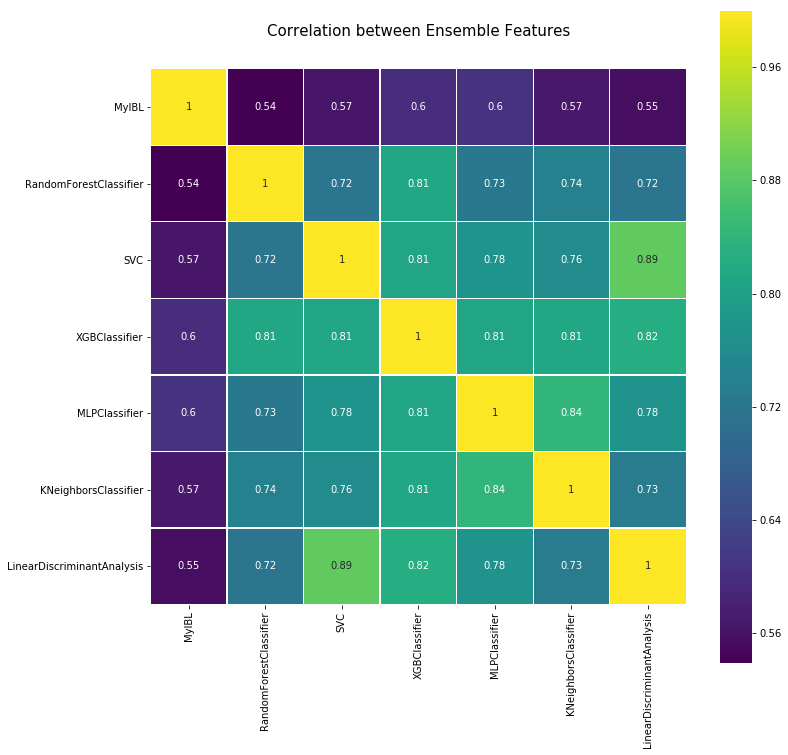

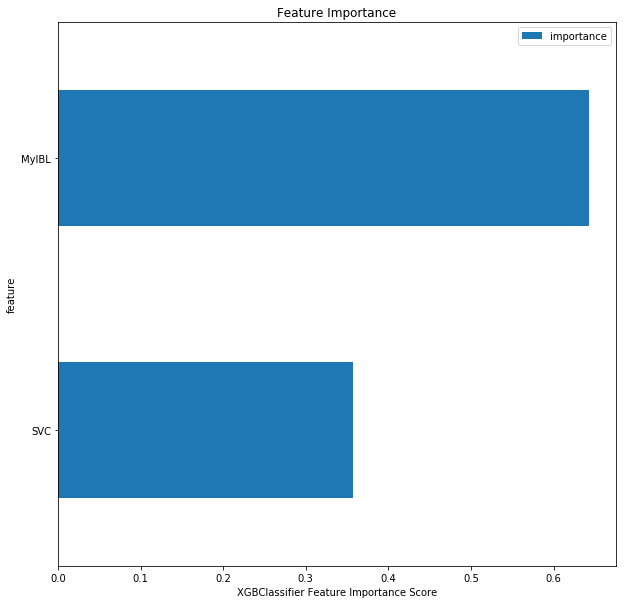

In [40]:
df_ens_features = df_ens_features2
df_ens_test = df_ens_test2
df_new_test = df_test2
labels = labels2
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_2, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [41]:
model_ens_2[0].score(df_test, labels_test)

0.7990430622009569

## Ensemble Standard pre-processing (removing outliers)


XGBClassifier
XGBClassifier 0.808 accuracy at validation stage, 0.20814251899719238 s


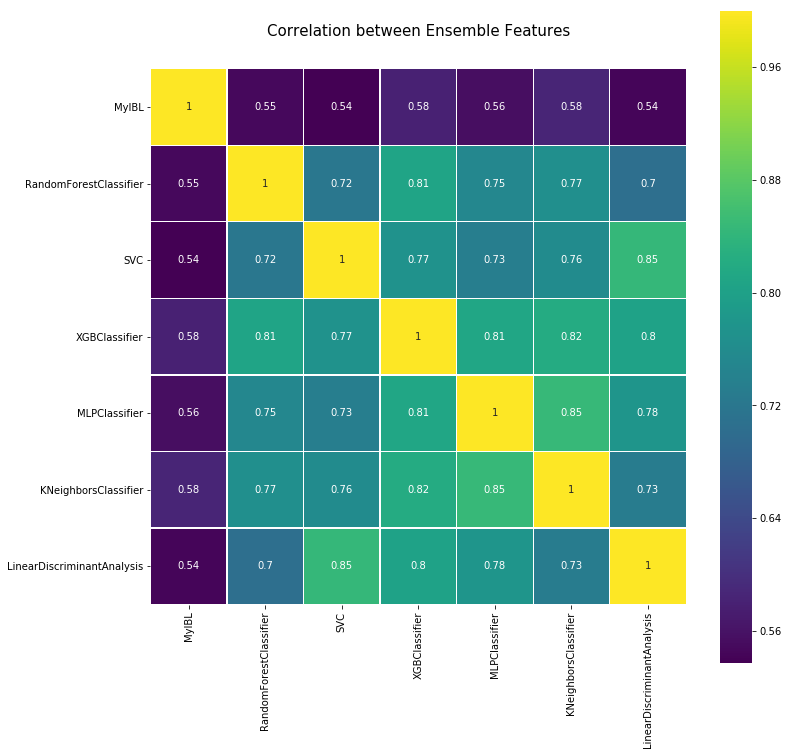

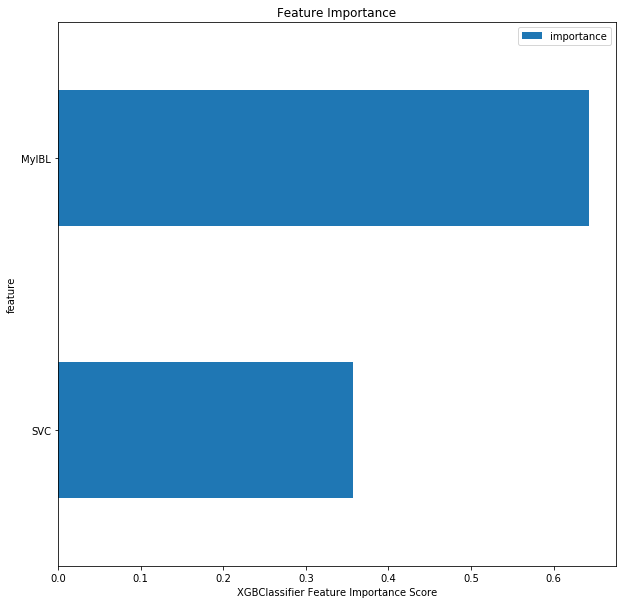

In [42]:
df_ens_features = df_ens_features2_o
df_ens_test = df_ens_test2_o
df_new_test = df_test2_o
labels = labels2_o
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_2_o, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [43]:
model_ens_2_o[0].score(df_test, labels_test)

0.7918660287081339

## Ensemble Categorized pre-processing (without removing outliers)


XGBClassifier
XGBClassifier 0.8316238779737619 accuracy at validation stage, 0.2281780242919922 s


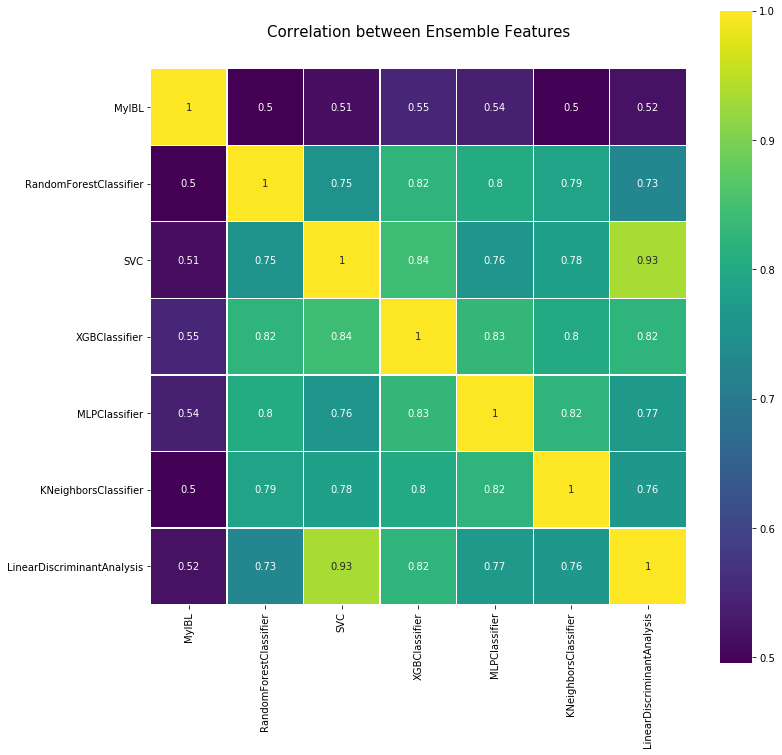

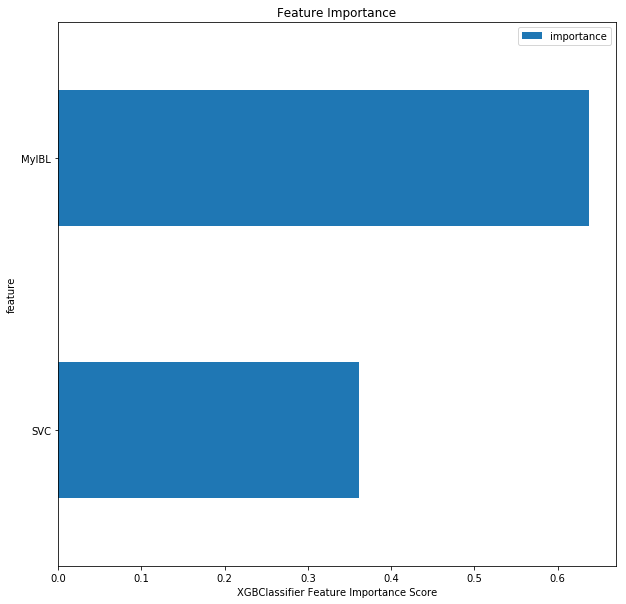

In [44]:
df_ens_features = df_ens_features3
df_ens_test = df_ens_test3
df_new_test = df_test3
labels = labels3
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
#xgb = XGB()
#xgb.fit(df_ens, labels)
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_3, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [45]:
model_ens_3[0].score(df_test, labels_test)

0.7799043062200957

## Ensemble Categorized pre-processing (removing outliers)


XGBClassifier
XGBClassifier 0.8085442827719088 accuracy at validation stage, 0.2611865997314453 s


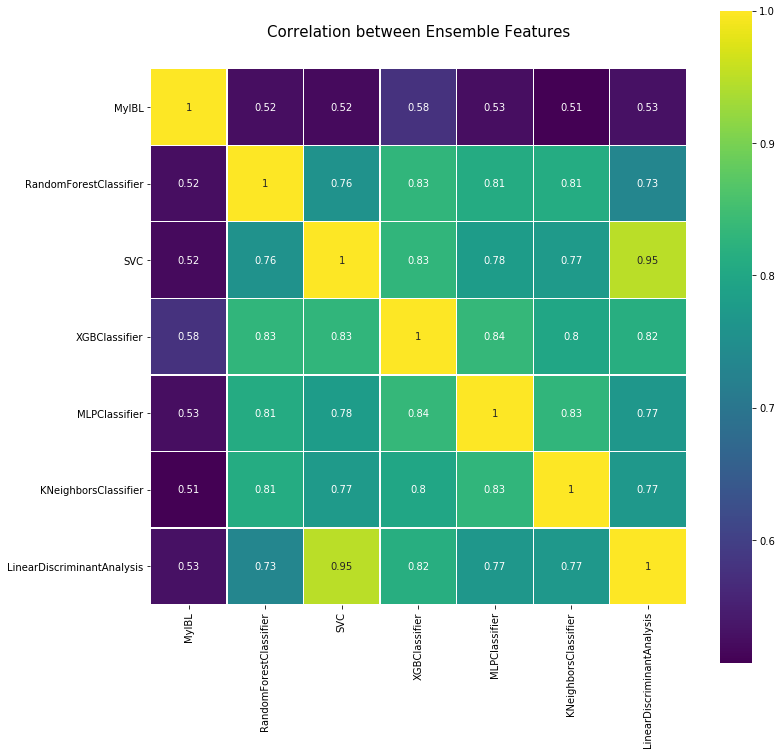

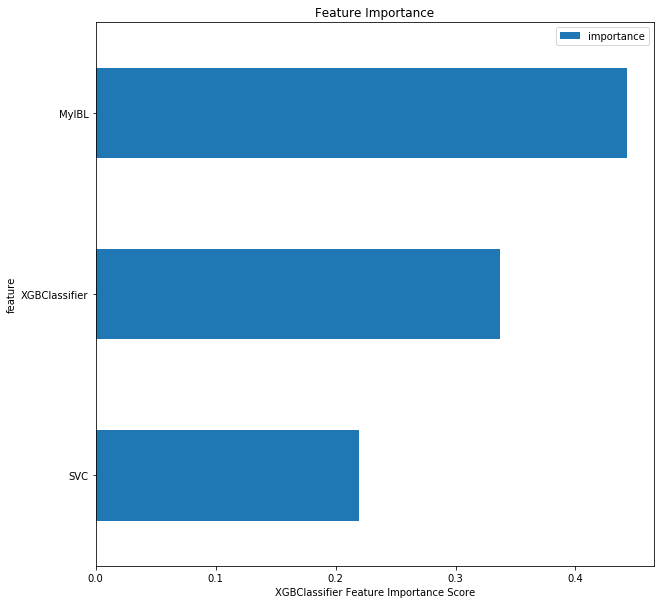

In [46]:
df_ens_features = df_ens_features3_o
df_ens_test = df_ens_test3_o
df_new_test = df_test3_o
labels = labels3_o
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'XGBClassifier', 'SVC']]
df_test = df_ens_test[['MyIBL', 'XGBClassifier', 'SVC']]
#xgb = XGB()
#xgb.fit(df_ens, labels)
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_3_o, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
#xgb.fit(df_ens, labels)

In [47]:
model_ens_3_o[0].score(df_test, labels_test)

0.7799043062200957

## Ensemble All pre-processing (without removing outliers)


XGBClassifier
XGBClassifier 0.8333460293277472 accuracy at validation stage, 0.21014809608459473 s


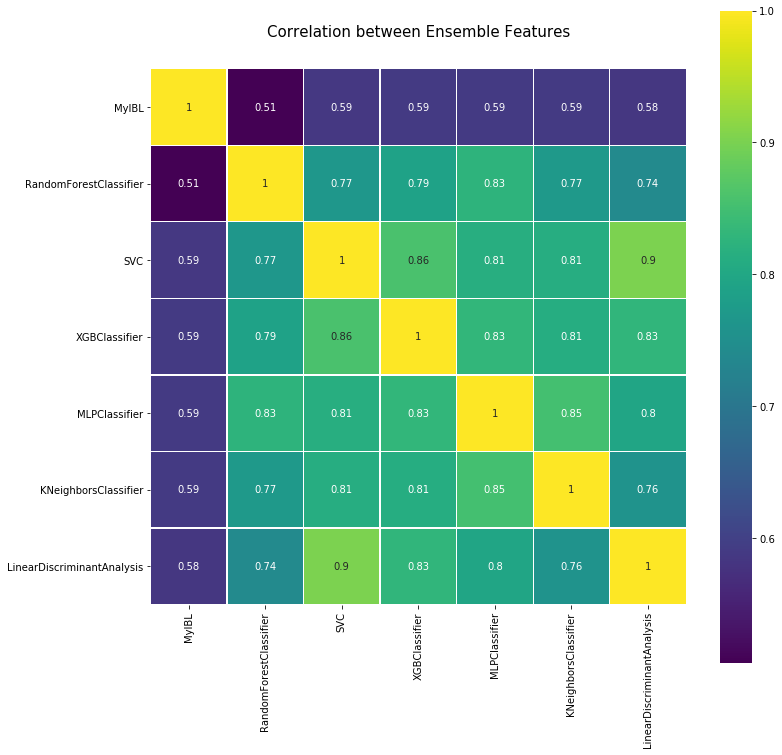

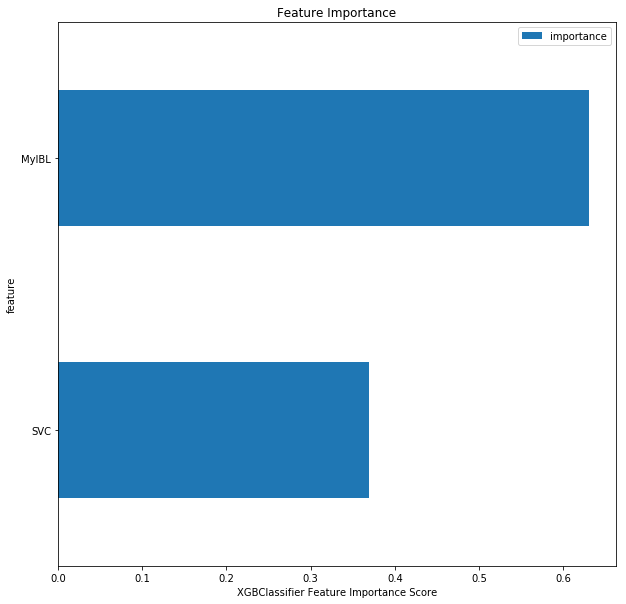

In [48]:
df_ens_features = df_ens_features4
df_ens_test = df_ens_test4
df_new_test = df_test4
labels = labels4
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
#xgb = XGB()
#xgb.fit(df_ens, labels)
train_idx, validation_idx = get_cv_data(df_train, cv=5)
clfs = [XGB()]
model_ens_4, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)

In [49]:
model_ens_4[0].score(df_test, labels_test)

0.7822966507177034

## Ensemble All pre-processing (removing outliers)


XGBClassifier
XGBClassifier 0.8310924903193043 accuracy at validation stage, 0.17614388465881348 s


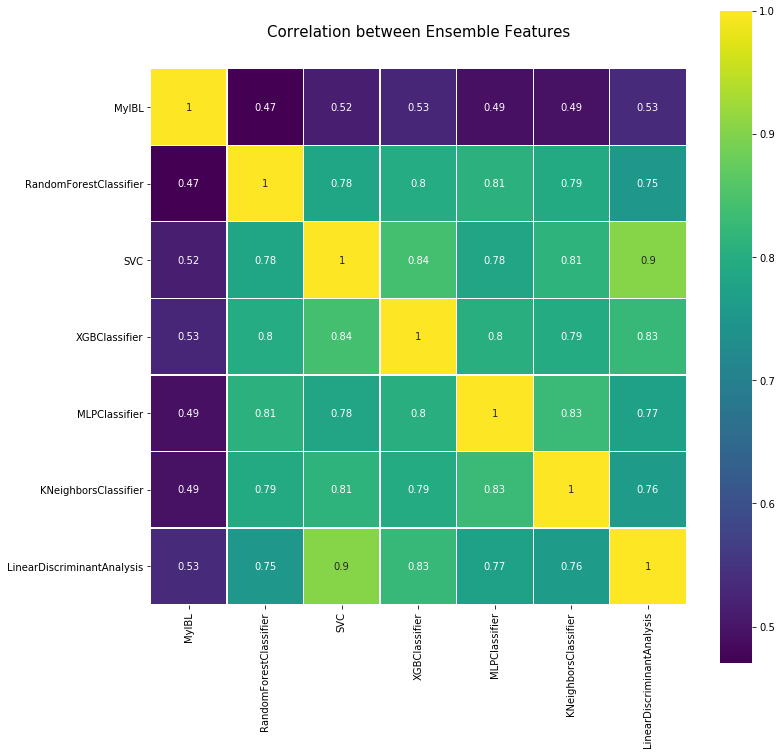

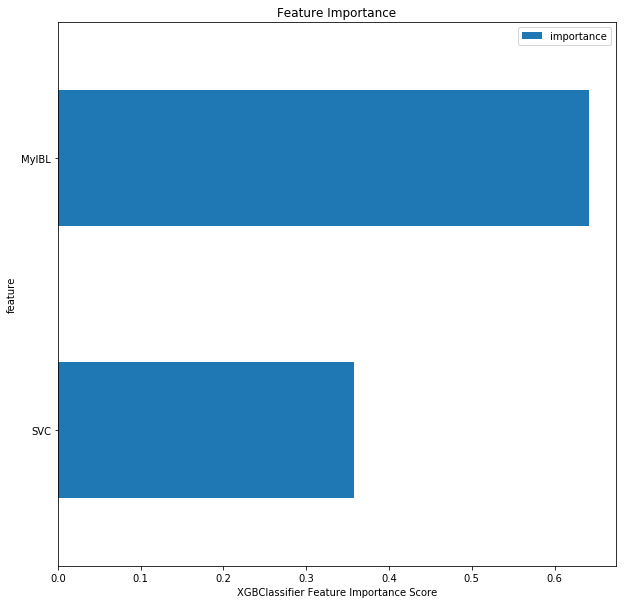

In [50]:
df_ens_features = df_ens_features4_o
df_ens_test = df_ens_test4_o
df_new_test = df_test4_o
labels = labels4_o
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
#xgb = XGB()
#xgb.fit(df_ens, labels)
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGB()]
model_ens_4_o, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)

In [51]:
model_ens_4_o[0].score(df_test, labels_test)

0.7822966507177034

In [52]:
df_ens_features.columns, df_ens_features.shape

(Index(['MyIBL', 'RandomForestClassifier', 'SVC', 'XGBClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis'], dtype='object'),
 (888, 7))

In [53]:
df_ens_test.columns, df_ens_test.shape

(Index(['MyIBL', 'RandomForestClassifier', 'SVC', 'XGBClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis'], dtype='object'),
 (418, 7))

Friedman test on 'accuracy'
17.565217391304348 0.007415756109115756


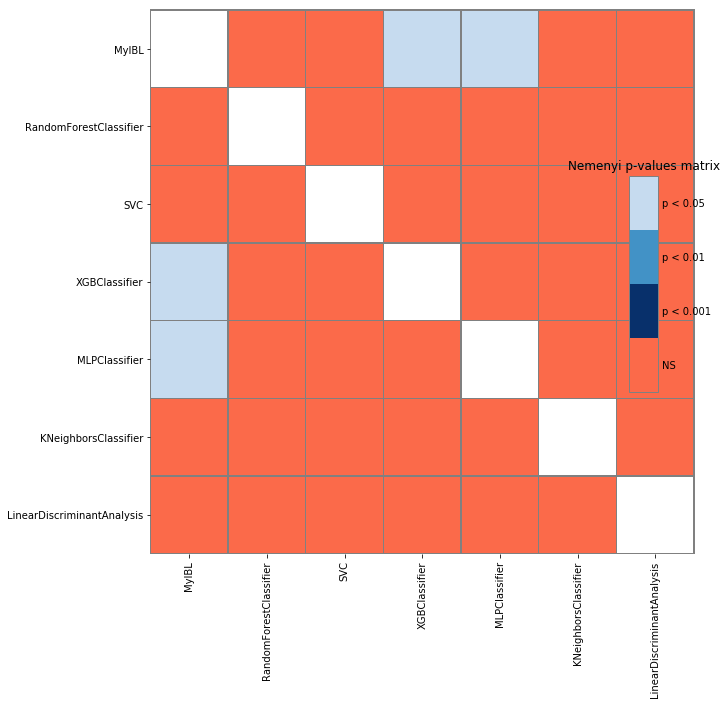

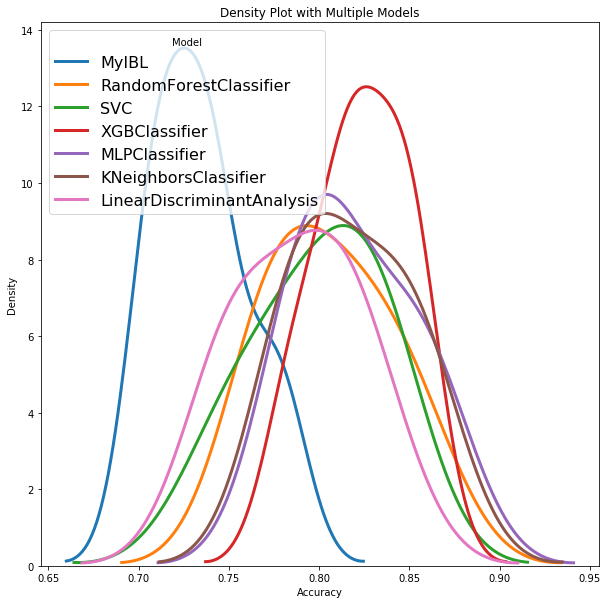

In [54]:
significance_test(df_model_cvaccuracies1)

Friedman test on 'accuracy'
15.152173913043475 0.01910559754407802


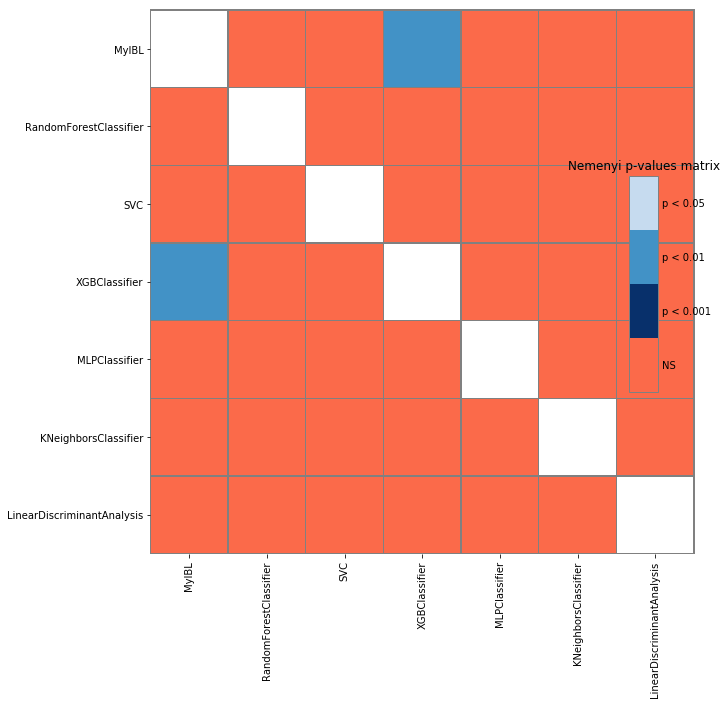

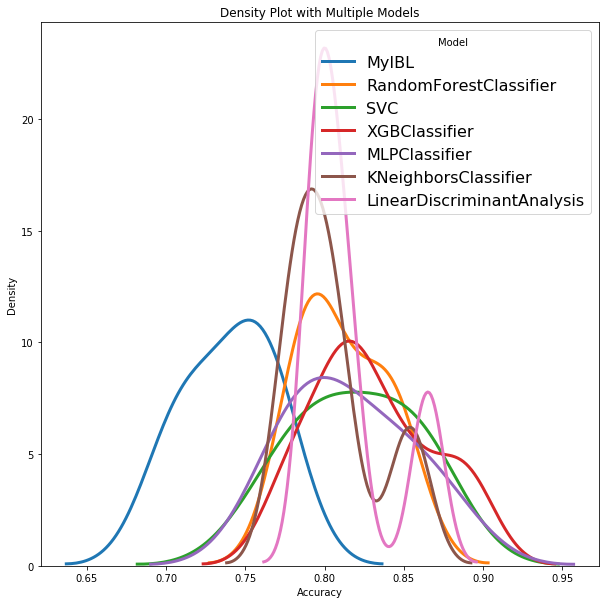

In [55]:
significance_test(df_model_cvaccuracies2)

Friedman test on 'accuracy'
18.021582733812945 0.006178484552204901


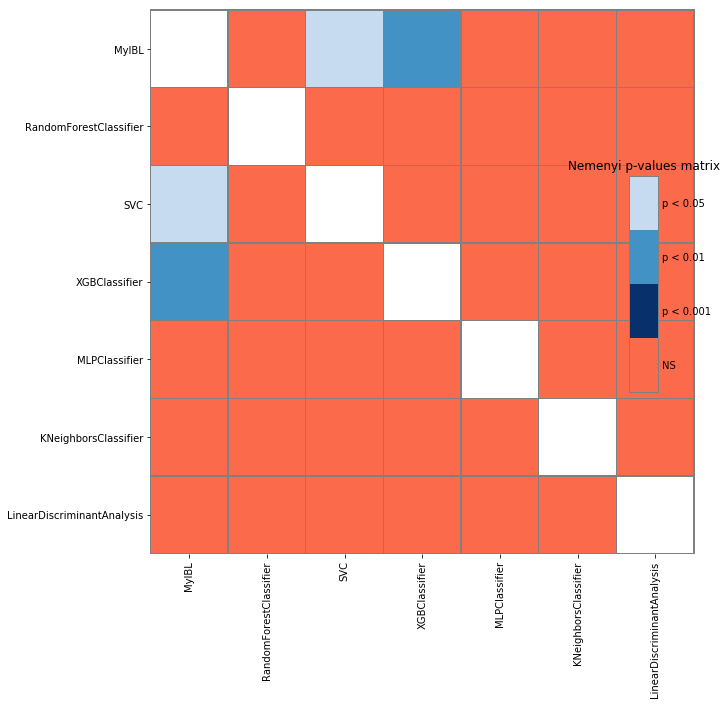

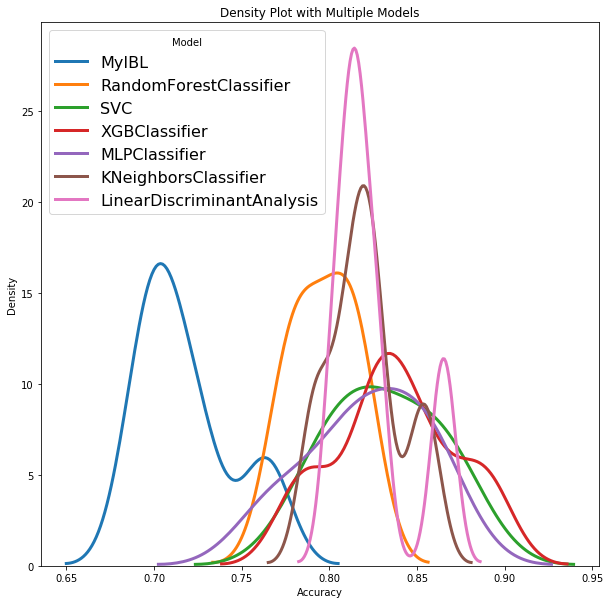

In [56]:
significance_test(df_model_cvaccuracies3)

Friedman test on 'accuracy'
22.162361623616224 0.0011315102291928625


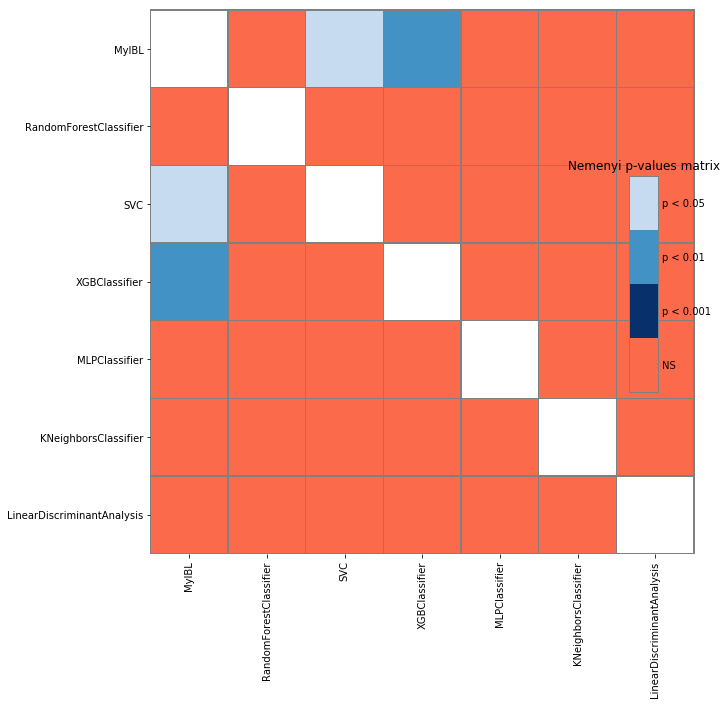

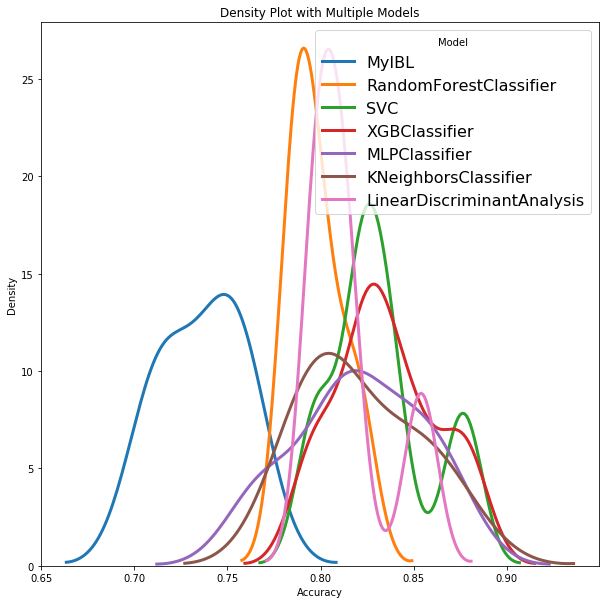

In [57]:
significance_test(df_model_cvaccuracies4)

In [58]:
df_train = df_train4.copy()
df_test = df_test4.copy()
labels_tmp = labels.copy()
df_train.shape

(891, 49)

In [59]:
from detect_outliers import detect_outliers
Outliers_to_drop = detect_outliers(df_train,19,df_train.columns)
len(Outliers_to_drop) # these can be removed

0

In [60]:
df_train.drop(Outliers_to_drop, inplace=True)
labels_tmp.drop(Outliers_to_drop, inplace=True)
df_train.shape

(891, 49)

In [61]:
clf=SVC()
clf.fit(df_train, labels_tmp)
clf.score(df_test,labels_test)

ValueError: Found input variables with inconsistent numbers of samples: [891, 888]